# SPU Inside

SPU is a virtual device backed by an MPC engine, which provides an *arithmetic black box* abstraction to front-end users. Just like other *black boxes*, it's not easy to understand what happened inside it.

For this reason, SPU provides some features to show what happened inside it, this document demonstrates these features. 

## Simulation

As the name suggests, *multi-party computation* is born to be distributed system with multiple participants, which makes it harder to setup, debug and inspect. So SPU provides a *simulation module* that uses threads to simulate multi-parties in a single process.  All parties acts exactly the same as in production environment, so we can use it as a playground to inspect the internals of SPU.

To use the simulation module, we can simple do

In [1]:
import spu
import jax.numpy as jnp
import numpy as np

# import spu simulation module
import spu.binding.util.simulation as pps

[2022-05-12 11:58:14.128] [info] [thread_pool.cc:18] Create a fixed thread pool with size 64


Now we can create SPU simulator and run program on it.

In [2]:
# create a simulator with ABY3 x Ring64 protocol.
protocol = spu.ProtocolKind.ABY3
field = spu.FieldType.FM64
simulator = pps.Simulator.simple(3, protocol, field)

# decorate a jnp function to a simulated function
spu_add = pps.sim_jax(simulator, jnp.add)

# now we can call spu_fn like normal jnp fn.
x = np.array([[1., 2.], [3., 4.]])
y = np.array([[5., 6.], [7., 8.]])

# the function is simulated on SPU VM, which use 3 threads to simulate different parties.
# the actual progress is exactly the same as real distributed version. 
z = spu_add(x, y)

print(z)

[[ 6.  8.]
 [10. 12.]]


In the above code.
- First, we create an SPU simulator backed by *ABY3* protocol with *FM64* field.
- Then we decorates a jax function `jax.add` to make it a SPU simulated function.
- Then we can use the simulated function just like normal python functions.

As the result suggests, it behaves like a python function, we can also print the compiled pphlo program with

In [3]:
print(spu_add.pphlo)

module @xla_computation_add.0 {
  func @main(%arg0: tensor<2x2x!pphlo.sec<f32>>, %arg1: tensor<2x2x!pphlo.sec<f32>>) -> tensor<2x2x!pphlo.sec<f32>> {
    %0 = "pphlo.add"(%arg0, %arg1) : (tensor<2x2x!pphlo.sec<f32>>, tensor<2x2x!pphlo.sec<f32>>) -> tensor<2x2x!pphlo.sec<f32>>
    return %0 : tensor<2x2x!pphlo.sec<f32>>
  }
}



The above code is a pphlo dialect in [MLIR](https://mlir.llvm.org/) format, which defines a `main` function that accepts two arguments and returns the sum as result.

Besides single `jax.numpy` op, we can simulate any jax function on SPU, i.e.

In [4]:
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

spu_sigmoid = pps.sim_jax(simulator, sigmoid)
spu_sigmoid(x)

print(spu_sigmoid.pphlo)

[2022-05-12 11:58:14.987] [info] [thread_pool.cc:18] Create a fixed thread pool with size 63
module @xla_computation_sigmoid.1 {
  func @main(%arg0: tensor<2x2x!pphlo.sec<f32>>) -> tensor<2x2x!pphlo.sec<f32>> {
    %0 = "pphlo.constant"() {value = dense<1.000000e+00> : tensor<2x2xf32>} : () -> tensor<2x2x!pphlo.pub<f32>>
    %1 = "pphlo.negate"(%arg0) : (tensor<2x2x!pphlo.sec<f32>>) -> tensor<2x2x!pphlo.sec<f32>>
    %2 = "pphlo.exponential"(%1) : (tensor<2x2x!pphlo.sec<f32>>) -> tensor<2x2x!pphlo.sec<f32>>
    %3 = "pphlo.add"(%2, %0) : (tensor<2x2x!pphlo.sec<f32>>, tensor<2x2x!pphlo.pub<f32>>) -> tensor<2x2x!pphlo.sec<f32>>
    %4 = "pphlo.divide"(%0, %3) : (tensor<2x2x!pphlo.pub<f32>>, tensor<2x2x!pphlo.sec<f32>>) -> tensor<2x2x!pphlo.sec<f32>>
    return %4 : tensor<2x2x!pphlo.sec<f32>>
  }
}



The above code is `spu function` which is composed of spu builtin ops.

Note: since spu use [JIT](https://en.wikipedia.org/wiki/Just-in-time_compilation) compilation, so we have to execute the function before printing the compiled bytecode.

## Profling

Besides simple simulation, we can profile the simulated program, although the profiling result could NOT be 
used as a reference of SPU perf, it still gives some information of what happened.

To use profiling, we have enabled some feature flags.

In [5]:
config = spu.RuntimeConfig(protocol=protocol, field=field)
config.enable_pphlo_profile = True
simulator = pps.Simulator(3, config)

`enable_pphlo_profile` tells SPU runtime to print information about pphlo, now, let's run the function on this new runtime.

In [6]:
spu_sigmoid = pps.sim_jax(simulator, sigmoid)
z = spu_sigmoid(x)

[2022-05-12 11:58:15.021] [info] [executor.cc:121] [Profiling] SPU execution completed, input processing took 8.141e-06s, execution took 0.005819865s, output processing took 7.908e-06s, total time 0.005836132s.
[2022-05-12 11:58:15.021] [info] [executor.cc:125] Detailed pphlo profiling data:
[2022-05-12 11:58:15.021] [info] [executor.cc:128] - pphlo.divide, executed 1 times, duration 0.003780705s
[2022-05-12 11:58:15.021] [info] [executor.cc:128] - pphlo.exponential, executed 1 times, duration 0.001587704s
[2022-05-12 11:58:15.021] [info] [executor.cc:128] - pphlo.constant, executed 1 times, duration 1.2125e-05s
[2022-05-12 11:58:15.021] [info] [executor.cc:128] - pphlo.add, executed 1 times, duration 1.4976e-05s
[2022-05-12 11:58:15.021] [info] [executor.cc:128] - pphlo.negate, executed 1 times, duration 3.4334e-05s


The above log tells the total execution time and the detailed statistics of each builtin function.

Besides the `enable_pphlo_profile` feature flag, SPU has other flags like `enable_hal_profile` to dump runtime information in different levels of instructions.

## Tracing

*Profiling* can only tell the statistics of SPU instructions, it's still hard to understand what happened inside it.
*Tracing* is a feature that used to print verbose `call stack`, which helps to understand/inspect what exactly happened.

To enable tracing features, just set `enable_action_trace` in the runtime config.

In [7]:
config = spu.RuntimeConfig(protocol=protocol, field=field)
config.enable_action_trace = True
simulator = pps.Simulator(3, config)

Now, let's run another function on this `tracing enabled` simulator.

In [8]:
spu_mul = pps.sim_jax(simulator, jnp.multiply)
z = spu_mul(x, y)

[SPU-TRACE]   hlo.mul(Value<2x2xSFXP>,Value<2x2xSFXP>)
[SPU-TRACE]     hal.f_mul(Value<2x2xSFXP>,Value<2x2xSFXP>)
[SPU-TRACE]       hal._mul(Value<2x2xSFXP>,Value<2x2xSFXP>)
[SPU-TRACE]         hal._mul_ss(Value<2x2xSFXP>,Value<2x2xSFXP>)
[SPU-TRACE]           mpc.mul_ss(ArrayRef<4xaby3.AShr<FM64>>,ArrayRef<4xaby3.AShr<FM64>>)
[SPU-TRACE]             mpc.mul_aa(ArrayRef<4xaby3.AShr<FM64>>,ArrayRef<4xaby3.AShr<FM64>>)
[SPU-TRACE]       hal._trunc(Value<2x2xS*>,0)
[SPU-TRACE]         hal._truncpr_s(Value<2x2xS*>,18)
[SPU-TRACE]           mpc.truncpr_s(ArrayRef<4xaby3.AShr<FM64>>,18)
[SPU-TRACE]             mpc.truncpr_a(ArrayRef<4xaby3.AShr<FM64>>,18)


At the first glance, the trace log is a bit of frustrating, so it worth a little while to explain it.

At the very begining, is the entry point of `multiply` function with format
```
module.op(value_type...)
```

So the first line `hlo.mul(Value<2x2xsfxp>,Value<2x2xsfxp>)` means:
- the module is `hlo`
- the operator is `mul`
- the two args are both `Value<2x2xsfxp>`

Note, `hlo` is short for `High Level Operations`, `hal` is short for `hardware abstraction layer`, `mpc` is short for `multi-party computation`.

The `Value<2x2xsfxp>` means it's a **S**ecret **F**i**X**ed **P**ointed tensor with shape(**2x2**). 

1. the runtime dispatches the function according parameters datatype (in this case *fxp*), then calls the corresponding fixed point handle function `hal.f_mul`, the prefix `f_` means its for fixed point.
2. the runtime dispatches `hal.f_mul` to the untyped version `hal._mul` which operate on `rings`.
3. the runtime dispatches `hal._mul` according to the *visibility* type, since both parameters are **secret**, so `hal._mul_ss` is called, the postfix `_ss` indicates it operates on two secrets.

Then the function `hal._mul_ss` is dispatched to the MPC layer, the signature becomes more complicated.
```
mpc.mul_ss(ArrayRef<4xaby3.AShr<FM64>>,ArrayRef<4xaby3.AShr<FM64>>)
```
The signature of operation is the same as above, `mpc.mul_ss` indicates the module is `mpc` and the operation is `mul_ss`.

The type `ArrayRef<4xaby3.AShr<FM64>>` has two notable differences:
1. unlike hal ops, mpc ops operates on 1D-array instead of tensor, which makes it a more standard SIMD instruction.
2. the type `aby3.AShr<FM64>` is protocol dependent, in this case, it's a *ABY3* arithmetic share in FM64.

Finally, it's dispatched to `mpc.mul_aa`, the postfix `_aa` indicates both parameters are arithmetic shares, then the ABY3 additive share add protocol is performed.

But `f_mul` could not be done with ring multiplication only, we have to `truncate` the result to make the fixed point legal, in the following three lines, `hal._trunc` is called and finally dispatched to `mpc.truncpr_a` protocol.

The above example is pretty straight forward, now let's make it harder.

Fixed point reciprocal is done with [Goldschmidt](https://en.wikipedia.org/wiki/Division_algorithm#Goldschmidt_division) approximation algorithm, the algorithm itself is not that simple, and when it's executed on MPC, things become more complicated.

It takes a lot of effort to understand how it works, let's directly see the tracing result.

In [9]:
spu_reciprocal = pps.sim_jax(simulator, jnp.reciprocal)
z = spu_reciprocal(x)

[SPU-TRACE]   hal.constant(PtBufferView<0x7f1fc404cfc0,xPT_F32,>,)
[SPU-TRACE]     hal.make_pub2k(PtBufferView<0x7f1fc404cfc0,xPT_F32,>)
[SPU-TRACE]   hal.broadcast_to(Value<xPFXP>,2x2)
[SPU-TRACE]   hlo.div(Value<2x2xPFXP>,Value<2x2xSFXP>)
[SPU-TRACE]     hal.dtype_cast(Value<2x2xPFXP>,FXP)
[SPU-TRACE]     hal.dtype_cast(Value<2x2xSFXP>,FXP)
[SPU-TRACE]     hal.f_div(Value<2x2xPFXP>,Value<2x2xSFXP>)
[SPU-TRACE]       hal.div_goldschmidt(Value<2x2xPFXP>,Value<2x2xSFXP>)
[SPU-TRACE]         hal._sign(Value<2x2xSFXP>)
[SPU-TRACE]           hal._msb(Value<2x2xSFXP>)
[SPU-TRACE]             hal._msb_s(Value<2x2xSFXP>)
[SPU-TRACE]               mpc.msb_s(ArrayRef<4xaby3.AShr<FM64>>)
[SPU-TRACE]                 mpc.a2b(ArrayRef<4xaby3.AShr<FM64>>)
[SPU-TRACE]                   mpc.add_bb(ArrayRef<4xaby3.BShr<FM64,64>>,ArrayRef<4xaby3.BShr<FM64,64>>)
[SPU-TRACE]                     mpc.xor_bb(ArrayRef<4xaby3.BShr<FM64,64>>,ArrayRef<4xaby3.BShr<FM64,64>>)
[SPU-TRACE]                     mpc.an

Surprise, it's really a lot of ops!

Yes, that's why MPC is still relatively slow and why SPU wants optimize it :P

The `reciprocal` is still a relative simple operator, you can try more complicated op like `convolution`.

## Misc

Simulation could be used to inspect other parts of SPU, i.e. the *fixed point arithmetic* accuracy.

As the above example indicates, non-linear functions like `reciprocal` and `exp` are approximated with some numeric methods, so the result is not as accurate as floating point arithmetic.

For example.

In [ ]:
%pip install matplotlib

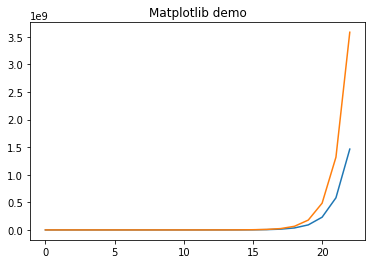

In [10]:
from matplotlib import pyplot as plt

simulator = pps.Simulator.simple(3, protocol, spu.FieldType.FM128)
spu_exp = pps.sim_jax(simulator, jnp.exp)

x = np.arange(0.,23.) 
spu_y = spu_exp(x)
jax_y = jnp.exp(x)
plt.title("Matplotlib demo") 
plt.plot(x,spu_y)
plt.plot(x,jax_y)
plt.show()

As we can see, the SPU version of `exp` (blue line) diverges with the standard version when input is larger. 

Finally, SPU, as a secure computation, behaves very differently from CPU, both in accuracy and cost model, when you are not sure about how it works, simulate on it! 